In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt   #그래프 출력시
import matplotlib as mpl    #그래프 옵션
import warnings
warnings.filterwarnings('ignore')

import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

sns.set_style('darkgrid')

#그래프 시각화 옵션 설정함수
%matplotlib inline

#그래프의 한글설정
mpl.rc('font',family='Malgun Gothic')

#그래프의 한글을 더욱 선명하게 출력
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#그래프에서 음수 값이 나올 때, 깨지는 현상 방지
mpl.rc('axes',unicode_minus=False)

In [2]:
train=pd.read_csv('ratings_train.txt',sep='\t')
test=pd.read_csv('ratings_test.txt',sep='\t')

# Preprocessing

In [33]:
train

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
...,...,...,...
149995,6222902,인간이 문제지 소는 뭔죄인가,0
149996,8549745,평점이 너무 낮아서,1
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
149998,2376369,청춘 영화의 최고봉방황과 우울했던 날들의 자화상,1


In [65]:
train.drop_duplicates(subset = ['document'], inplace=True)
train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train['document'] = train['document'].replace('', np.nan)
train = train.dropna()

In [66]:
test.drop_duplicates(subset = ['document'], inplace=True)
test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test['document'] = test['document'].replace('', np.nan)
test = test.dropna()

In [67]:
okt = Okt()
stopwords = ['과','도','를','으로','자','에','와','한','하다','의','가','이','은','들','는','좀','잘']

In [68]:
X_train = []
for sentence in train['document']:
    temp = []
    temp = okt.morphs(sentence, stem=True) 
    temp = [word for word in temp if not word in stopwords] 
    X_train.append(temp)

In [69]:
X_test = []
for sentence in test['document']:
    temp = []
    temp = okt.morphs(sentence, stem=True)
    temp = [word for word in temp if not word in stopwords]
    X_test.append(temp)

In [70]:
Y_train=train['label']

In [71]:
Y_test=test['label']

# Tokenize & Padding

In [72]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '좋다': 7, '너무': 8, '다': 9, '정말': 10, '되다': 11, '적': 12, '만': 13, '재밌다': 14, '같다': 15, '진짜': 16, '로': 17, '아니다': 18, '않다': 19, '점': 20, '에서': 21, '만들다': 22, '나오다': 23, '연기': 24, '것': 25, '평점': 26, '내': 27, '최고': 28, '그': 29, '나': 30, '안': 31, '인': 32, '스토리': 33, '생각': 34, '못': 35, '왜': 36, '드라마': 37, '게': 38, '사람': 39, '감동': 40, '보고': 41, '이렇다': 42, '고': 43, '말': 44, '아깝다': 45, '더': 46, '배우': 47, '때': 48, 'ㅋㅋ': 49, '아': 50, '감독': 51, '거': 52, '그냥': 53, '요': 54, '재미있다': 55, '재미': 56, '시간': 57, '내용': 58, '까지': 59, '뭐': 60, '중': 61, '주다': 62, '자다': 63, '하고': 64, '지루하다': 65, '수': 66, '재미없다': 67, '네': 68, '쓰레기': 69, '모르다': 70, '가다': 71, '들다': 72, '그렇다': 73, '싶다': 74, '지': 75, '작품': 76, '사랑': 77, '알다': 78, '하나': 79, '다시': 80, '마지막': 81, '볼': 82, '정도': 83, '저': 84, '이건': 85, '오다': 86, '완전': 87, 'ㅋ': 88, 'ㅠㅠ': 89, '많다': 90, '처음': 91, 'ㅋㅋㅋ': 92, '장면': 93, '액션': 94, '주인공': 95, '이렇게': 96, '안되다': 97, '걸': 98, '차다': 99, '나다': 100, '개': 101, '하': 1

In [73]:
threshold = 5
total = len(tokenizer.word_index) 
rare = 0 
total_ = 0 
rare_ = 0 


for key, value in tokenizer.word_counts.items():
    total_ = total_ + value

    if(value < threshold):
        rare = rare + 1
        rare_ = rare_ + value

print('단어 집합의 크기 :',total)
print('빈도가 %s번 이하인 희귀 단어 수: %s'%(threshold - 1, rare))
print("집합에서 희귀 단어 비율:", (rare / total)*100)
print("전체 빈도에서 희귀 단어 빈도 비율:", (rare_ / total_)*100)

단어 집합의 크기 : 43753
빈도가 4번 이하인 희귀 단어 수: 29516
집합에서 희귀 단어 비율: 67.46051699312046
전체 빈도에서 희귀 단어 빈도 비율: 2.973891099679705


In [74]:
size = total - rare + 1 
print('단어 집합 크기 :',size)

단어 집합 크기 : 14238


In [75]:
tokenizer = Tokenizer(size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [76]:
drop1 = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop2 = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [77]:
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [78]:
X_train = np.delete(X_train, drop1, axis=0)
Y_train = np.delete(Y_train, drop1, axis=0)
X_test = np.delete(X_test, drop2, axis=0)
Y_test = np.delete(Y_test, drop2, axis=0)

Max length : 69
Mean length : 10.809095284933973


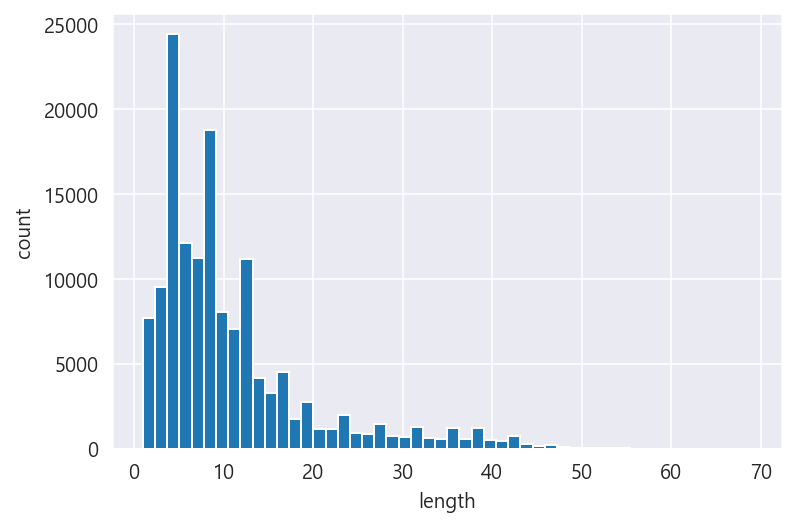

In [79]:
print('Max length :',max(len(l) for l in X_train))
print('Mean length :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)

plt.xlabel('length')
plt.ylabel('count')
plt.show()

In [80]:
def under(max_len, list):
    a = 0
    for s in list:
        if(len(s) <= max_len):
            a = a + 1
    print('길이가 %s 이하인 비율: %s'%(max_len, (a / len(list))*100))

In [81]:
max_len = 25
under(max_len, X_train)

길이가 25 이하인 비율: 91.83391582780487


In [83]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [85]:
X_train

array([[    0,     0,     0, ...,    16,   262,   660],
       [    0,     0,     0, ...,   962,   677,    19],
       [    0,     0,     0, ...,     2,   221,     9],
       ...,
       [    0,     0,     0, ..., 10464, 10400,  1044],
       [    0,     0,     0, ...,  1233,   541,  7847],
       [    0,     0,     0, ...,    58,  1357,     1]])

# Modeling

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

## RandomForest

In [89]:
rf=RandomForestClassifier()
rf.fit(X_train,Y_train)
pred=rf.predict(X_test)
accuracy_score(Y_test,pred)

0.6482237182806836

## XGB

In [90]:
xgb=XGBClassifier()
xgb.fit(X_train,Y_train)
pred=xgb.predict(X_test)
accuracy_score(Y_test,pred)

0.729839461418954

## LSTM

In [91]:
from tensorflow.keras.layers import Embedding, Dense, LSTM,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [92]:
model = Sequential()
model.add(Embedding(size, 100))
model.add(LSTM(256))
Dropout(0.3)
model.add(Dense(1, activation='sigmoid'))

In [93]:
early = EarlyStopping(monitor='val_loss', verbose=1, patience=5)

In [94]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, Y_train, epochs=20, callbacks=[early], batch_size=100, validation_split=0.2)

Train on 114679 samples, validate on 28670 samples
Epoch 1/20
114679/114679 [==============================] - 132s 1ms/sample - loss: 0.3960 - acc: 0.8200 - val_loss: 0.3589 - val_acc: 0.8450
Epoch 2/20
114679/114679 [==============================] - 137s 1ms/sample - loss: 0.3288 - acc: 0.8567 - val_loss: 0.3397 - val_acc: 0.8533
Epoch 3/20
114679/114679 [==============================] - 141s 1ms/sample - loss: 0.3042 - acc: 0.8697 - val_loss: 0.3323 - val_acc: 0.8569
Epoch 4/20
114679/114679 [==============================] - 138s 1ms/sample - loss: 0.2861 - acc: 0.8799 - val_loss: 0.3330 - val_acc: 0.8588
Epoch 5/20
114679/114679 [==============================] - 136s 1ms/sample - loss: 0.2689 - acc: 0.8894 - val_loss: 0.3319 - val_acc: 0.8572
Epoch 6/20
114679/114679 [==============================] - 138s 1ms/sample - loss: 0.2526 - acc: 0.8972 - val_loss: 0.3444 - val_acc: 0.8568
Epoch 7/20
114679/114679 [==============================] - 142s 1ms/sample - loss: 0.2354 - acc:

In [95]:
model.evaluate(X_test,Y_test)[1]

48275/48275 [==============================] - 33s 687us/sample - loss: 0.4106 - acc: 0.8430


0.8429622